In [1]:
import torch
from torch.autograd.grad_mode import no_grad 
import torch.nn as NN
import torch.nn.functional as F
import time
from torch.nn.modules import padding 
import torch.optim as optim
from torchvision import datasets
import matplotlib.pyplot as plt
from torchvision import transforms
import numpy as np
from torchsummary import summary

In [2]:
start=time.perf_counter()

batch_size=128
learning_rate=1e-4
momentum=0.9
n_epochs=100

In [3]:
torch.manual_seed(6)

train_dataset=datasets.MNIST(
    root='./data',train=True,transform=transforms.ToTensor(),download=True)

test_dataset=datasets.MNIST(
    root='./data',train=False,transform=transforms.ToTensor(),download=False)

train_loader=torch.utils.data.DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
test_loader=torch.utils.data.DataLoader(test_dataset,batch_size=batch_size,shuffle=True) 

class CNN(NN.Module):
    def __init__(self,n_featuremap,n_output):
        super().__init__()
        self.L1Conv=NN.Conv2d(n_featuremap,6,5,stride=1,padding=2)
        self.L1Activation=NN.ReLU(inplace=True)
        self.L1Pooling=NN.MaxPool2d(2,2)
        
        self.L2Conv=NN.Conv2d(6,16,5,stride=1,padding=0)
        self.L2Activation=NN.ReLU(inplace=True)
        self.L2Pooling=NN.MaxPool2d(2,2)
        
        self.L3Linear=NN.Linear(400,120)
        self.L3Activation=NN.ReLU(inplace=True)
        
        self.L4Linear=NN.Linear(120,84)
        self.L4Activation=NN.ReLU(inplace=True)        
        
        self.L5Linear=NN.Linear(84,n_output)
    
    def forward(self,x):
        # L1z=self.L1Conv(x)
        # L1a=self.L1Activation(L1z)
        # L1p=self.L1Pooling(L1a)

        # L2z=self.L2Conv(L1p)
        # L2a=self.L2Activation(L2z)
        # L2p=self.L2Pooling(L2a)

        # L3z=self.L3Activation(L2p.view(L2p.size(0),-1))
        # L3a=self.L3Activation(L3z)

        # L4z=self.L4Linear(L3a)
        # L4a=self.L4Activation(L4z)

        # L5z=self.L5Linear(L4a)
        # L5softmax=torch.softmax(L5z,dim=1)
        # L5ouput=torch.log(L5softmax)

        L1z = self.L1Conv(x)
        L1a = self.L1Activation(L1z)
        L1p = self.L1Pooling(L1a)
        L2z = self.L2Conv(L1p)
        L2a = self.L2Activation(L2z)
        L2p = self.L2Pooling(L2a)
        L3z = self.L3Linear(L2p.view(L2p.size(0), -1))
        L3a = self.L3Activation(L3z)
        L4z = self.L4Linear(L3a)
        L4a = torch.relu(L4z)
        L5z = self.L5Linear(L4a)
        L5softmax=torch.softmax(L5z, dim =1)
        L5ouput=torch.log(L5softmax)
        return L5ouput

    def learning(self,X,y,loss_func,optimizer):
        prediction=self.forward(X)
        loss=loss_func(prediction,y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        return loss

Epoch:0,Loss:2.295285 Accuracy:0.112367 on training set 0.113500 on test set
Epoch:1,Loss:2.296201 Accuracy:0.112367 on training set 0.113500 on test set
Epoch:2,Loss:2.298669 Accuracy:0.112400 on training set 0.113500 on test set
Epoch:3,Loss:2.295857 Accuracy:0.112683 on training set 0.113900 on test set
Epoch:4,Loss:2.297021 Accuracy:0.114833 on training set 0.115600 on test set
Epoch:5,Loss:2.300062 Accuracy:0.120917 on training set 0.120300 on test set
Epoch:6,Loss:2.292690 Accuracy:0.133000 on training set 0.131500 on test set
Epoch:7,Loss:2.293425 Accuracy:0.145450 on training set 0.145700 on test set
Epoch:8,Loss:2.293811 Accuracy:0.165233 on training set 0.168600 on test set
Epoch:9,Loss:2.277070 Accuracy:0.217633 on training set 0.223800 on test set
Epoch:10,Loss:2.283105 Accuracy:0.293467 on training set 0.304600 on test set
Epoch:11,Loss:2.270526 Accuracy:0.347183 on training set 0.357000 on test set
Epoch:12,Loss:2.266557 Accuracy:0.396067 on training set 0.398200 on test 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


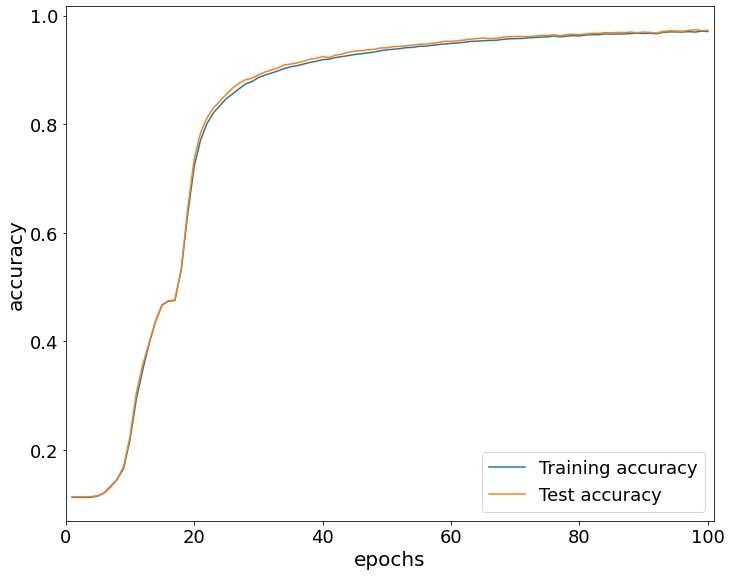

In [4]:
n_featuremap=1
n_output=10
# SMR = CNN(n_featuremap,n_output)
# summary(SMR.to(device), (1,28,28))
# SMR = SMR.to(device)
SMR=CNN(n_featuremap,n_output)
# SMR=SMR.to(device)

optimizer=optim.SGD(SMR.parameters(),lr=learning_rate,momentum=momentum)
loss_fn=NN.NLLLoss()   

accuracy_tensor_tr=torch.zeros(n_epochs)
accuracy_tensor_te=torch.zeros(n_epochs)
for epoch in range(n_epochs):
    for imgs,labels in train_loader:
        # imgs=imgs.to(device)
        # labels=labels.to(device)

        batch_size=imgs.shape[0]
        loss=SMR.learning(imgs,labels,loss_fn,optimizer)

    correct_tr=0
    total_tr=0
    with torch.no_grad():
        for imgs,labels in train_loader:
            # imgs=imgs.to(device)
            # labels=labels.to(device)

            batch_size=imgs.shape[0]
            outputs=SMR.forward(imgs)
            _,predicted=torch.max(outputs,dim=1)
            total_tr+=labels.shape[0]
            correct_tr+=int((predicted==labels).sum())

    correct_te=0
    total_te=0
    with torch.no_grad():
        for imgs,labels in test_loader:
            # imgs=imgs.to(device)
            # labels=labels.to(device)
            batch_size=imgs.shape[0]
            outputs=SMR.forward(imgs)
            _,predicted=torch.max(outputs,dim=1)
            total_te+=labels.shape[0]
            correct_te+=int((predicted==labels).sum())            
    
    print('Epoch:%d,Loss:%f Accuracy:%f on training set %f on test set' %(epoch,float(loss),correct_tr/total_tr,correct_te/total_te))
    accuracy_tensor_tr[epoch]=correct_tr/total_tr
    accuracy_tensor_te[epoch]=correct_te/total_te    

elapsed=(time.perf_counter()-start)
print('Time used:',elapsed,'s')

torch.save(accuracy_tensor_tr,'./accuracy_tensor_trcpu1.pt')
torch.save(accuracy_tensor_te,'./accuracy_tensor_tecpu1.pt')


fig=plt.figure(figsize=(10,8))
plt.plot(range(1,n_epochs+1),accuracy_tensor_tr,label='Training accuracy')
plt.plot(range(1,n_epochs+1),accuracy_tensor_te,label='Test accuracy')

plt.xlabel('epochs',fontsize=20)
plt.ylabel('accuracy',fontsize=20)
plt.xlim(0,n_epochs+1)
plt.legend(fontsize=18)
plt.tight_layout()
plt.tick_params(axis='both',labelsize=18)
fig.savefig('accuracy_plotcpu1.png',bbox_inches='tight')
fig.savefig('accuracy_plotcpu1.eps',bbox_inches='tight')
fig.savefig('accuracy_plotcpu1.pdf',bbox_inches='tight')